# Pocket-level evaluation for P2Rank on LIGYSIS
Validate the pipeline by comparing the results with LIGYSIS evaluation paper.

In [28]:
import csv
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

sys.path.append('/home/vit/projects/cryptoshow-analysis/src/utils')
import cryptoshow_utils

P2RANK_PREDICTIONS_PATH = '/home/vit/Projects/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions/p2rank_predictions_auth.pkl'
DATA_PATH='/home/vit/Projects/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_for_pocket_level_evaluation.csv'

def read_predicted_pockets_p2rank(predictions):
    reformated_predicted_pockets = {}
    sequences = {}

    for protein_id, predicted_pockets in predictions.items():
        pdb_id, chain_id = protein_id[:4], protein_id[4:]
        this_reformated_pockets = []
        for predicted_pocket in predicted_pockets:
            predicted_pocket = [i[1:] for i in predicted_pocket]
            reformated_predicted_pocket, sequence = cryptoshow_utils.map_auth_to_mmcif_numbering(pdb_id, chain_id, predicted_pocket)
            this_reformated_pockets.append((reformated_predicted_pocket, 'p2rank'))
            sequences[protein_id] = sequence
        reformated_predicted_pockets[protein_id] = this_reformated_pockets

    return reformated_predicted_pockets, sequences
with open(P2RANK_PREDICTIONS_PATH, 'rb') as f:
    predicted_pockets = pickle.load(f)
# reformated_predicted_pockets = read_predicted_pockets_p2rank(predicted_pockets)
# with open('/home/vit/Projects/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions/p2rank_predictions_reformated.pkl', 'wb') as f:
#     pickle.dump(reformated_predicted_pockets, f)
with open('/home/vit/Projects/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions/p2rank_predictions_reformated.pkl', 'rb') as f:
    reformated_predicted_pockets = pickle.load(f)

## Test on LIGYSIS pockets
Validate the pipeline by re-runing the evaluation on P2Rank and comparing to results in LIGYSIS evaluation paper.

In [29]:
# load CB test set and P2Rank predictions
sys.path.append('/home/vit/projects/cryptoshow-analysis/src/utils')
from eval_utils import read_test_binding_residues

binding_residues, _ = read_test_binding_residues(data_path=DATA_PATH, pocket_types=['NON_CRYPTIC'])
binding_residues = { protein_id.replace('_', ''): i for protein_id, i in binding_residues.items()}
predicted_pockets = {key:[(np.array([int(ii[1:]) for ii in i]), model) for i, model in pockets] for key, pockets in reformated_predicted_pockets[0].items()}

In [ ]:
p2rank_count = 0
for i in binding_residues.keys():
    if i not in predicted_pockets:
        print(f'Warning: {i} not in predicted pockets!') 
        predicted_pockets[i] = []
    else:
        print(f'{i} has {len(predicted_pockets[i])} predicted pockets and {len(binding_residues[i])} binding residues.')
        p2rank_count += 1

In [31]:
print(f'{p2rank_count / len(binding_residues) * 100:.2f}% ({p2rank_count} / {len(binding_residues)})')
print('The LIGYSIS evaluation paper says "2759 (92.9)" (see Table 3). I guess the "2759" is a typo and it should be "2579".')

92.94% (2579 / 2775)
The LIGYSIS evaluation paper says "2759 (92.9)" (see Table 3). I guess the "2759" is a typo and it should be "2579".


## Compute metrics and plot
Compute DCC, coverage, dice coefficient and plot histograms.

0.21171171171171171 0.5839872130194711


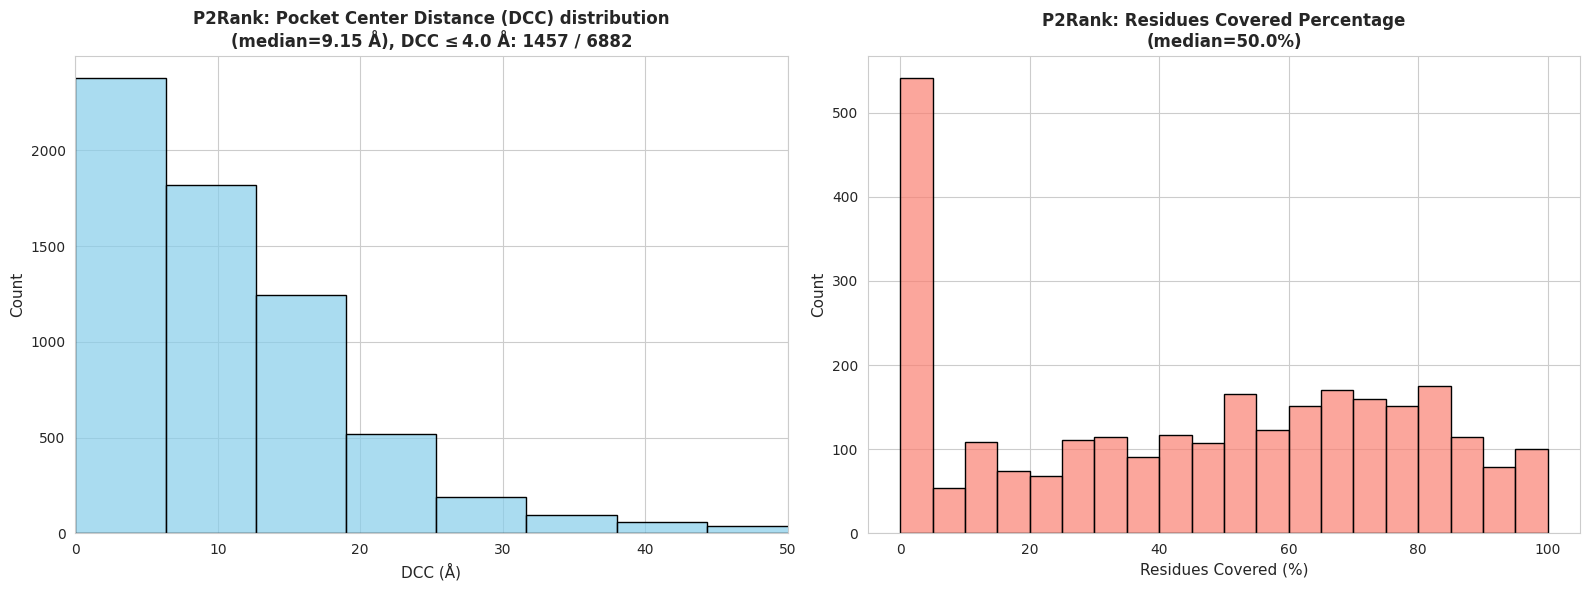

/home/vit/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vit/.local/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


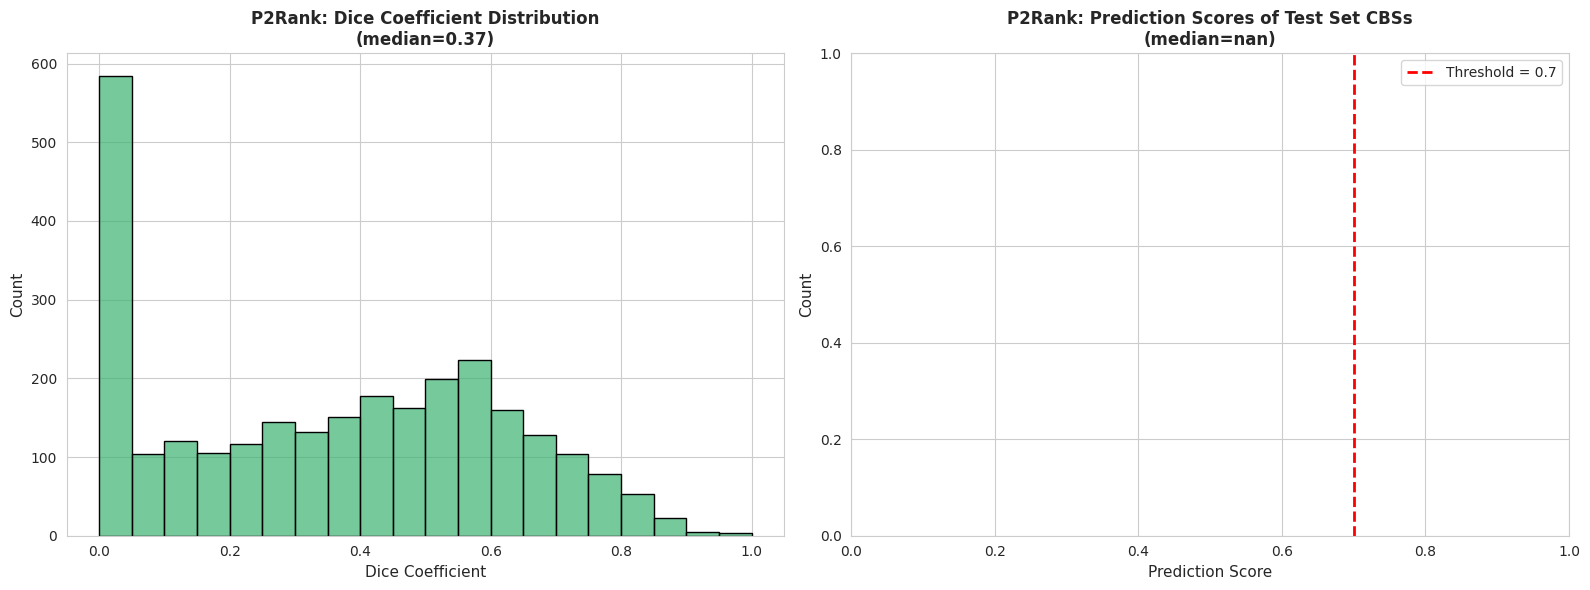

In [35]:
import eval_utils
COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'
DCC_THRESHOLD = 4.0  # in Angstroms
MODEL = 'P2Rank'

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predicted_pockets, {}, COORDINATES_DIR)
print(np.sum(np.array(DCCs) < 4) / number_of_pockets, np.sum(np.array(DCCs) < 12) / number_of_pockets)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)